<a href="https://colab.research.google.com/github/park-geun-hyeong/Kaggle_project/blob/main/NLP/nlp_disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATA LOAD from kaggle

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parkgnyeong","key":"568f836a456be02afdc39fa1b9466285"}'}

In [2]:
ls kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle competitions download -c nlp-getting-started

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 60.9MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 22.9MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 61.4MB/s]


## DATA 확인하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

path='/content/drive/MyDrive/Kaggle/NLP/kaggle_nlp_disaster/'

In [2]:
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'sample_submission.csv')

In [3]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [5]:
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


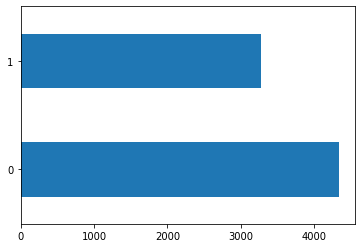

In [6]:
train['target'].value_counts()
train['target'].value_counts().plot.barh()

In [7]:
y_train = train['target']
del train['keyword']
del train['location']
del test['keyword']
del test['location']

## text 전처리


In [8]:
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
print(stopwords[:10])
print(len(stopwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
179


In [10]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^A-Za-z ]','',text)
    text = [word for word in text.split() if not word in stopwords]
    
    return text

In [11]:
del train['id']
del train['target']

In [12]:
train['text'] = train['text'].apply(lambda x : preprocess(x))
test['text'] = test['text'].apply(lambda x : preprocess(x))

In [13]:
x_train = train['text']
x_test = test['text']

In [168]:
x_train

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610           [utckm, volcano, hawaii, httptcozdtoydebj]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object

## Word Tokenizer

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

token=Tokenizer() #사용빈도수가 많은 단어가 작은 숫자로 index되어진다.

In [17]:
token.fit_on_texts(x_train)

In [18]:
len(token.index_word)  #전체 토큰화 되어진 단어 개수 

21539

In [77]:
total_word = len(token.index_word)
rare_word = 0
total_freq = 0
rare_freq = 0

for key, value in token.word_counts.items():
    total_freq = total_freq + value

    if value < 2:
        rare_word += 1
        rare_freq = rare_freq + value

print("토큰화 되어진 단어 개수 :{}".format(total_word)) 
print("사용개수가 1 이하인 토큰의 개수: {}".format(rare_word))
print("2이하인 토큰 단어의 사용 비율: {}".format(rare_freq/ total_freq))       

### Tokenizer의 maxlen을 사용개수가 3이상인 단어개수로 설정해 주자(나머지는 oov처리)

토큰화 되어진 단어 개수 :21539
사용개수가 1 이하인 토큰의 개수: 15154
2이하인 토큰 단어의 사용 비율: 0.20557273861848174


In [78]:
vocab_size = total_word - rare_word + 2 ##0,1제외하므로 +2
print(vocab_size)

6387


In [79]:
tk = Tokenizer(vocab_size, oov_token = "OOV")

In [80]:
tk.fit_on_texts(x_train) ## 각 단어들을 정수 인코딩 해주었다(oov값=1)
x_train_seq = tk.texts_to_sequences(x_train)
x_test_seq = tk.texts_to_sequences(x_test)

## Word Padding

In [81]:
print(x_train_seq[:3])

[[4213, 737, 147, 57, 1541, 4214, 13], [95, 5, 128, 524, 1, 1, 1209], [1542, 1413, 1911, 540, 1, 1543, 155, 1911, 540, 1210, 930]]


In [82]:
word_num=[]

for idx, sen in enumerate(x_train_seq):
    words_num = len(sen)
    word_num.append(words_num)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


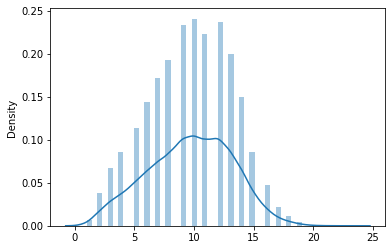

In [83]:
##단어길이의 분포 확인하기

sns.distplot(word_num,bins=50)


In [84]:
drop_idx = [idx for idx, sen in enumerate(x_train_seq) if len(sen) < 1] ##word num이 0이하인 row는 없다.
print(len(drop_idx))

0


In [85]:
over_20 = [idx for idx, sen in enumerate(x_train_seq) if len(sen) > 20]

In [86]:
over_20 ## word수가 20 이상인 idx는 2개뿐인것으로 보아 padding size = 20으로 설정해주자

[1540, 1942]

In [87]:
x_train_pad = pad_sequences(x_train_seq, maxlen=20)
x_test_pad = pad_sequences(x_test_seq, maxlen=20)

In [88]:
x_train_pad.shape, x_test_pad.shape

((7613, 20), (3263, 20))

In [89]:
y_train=np.array(y_train)
y_train

array([1, 1, 1, ..., 1, 1, 1])

##Model


In [133]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, BatchNormalization,Conv1D,GlobalAveragePooling1D,GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [91]:
mc = ModelCheckpoint('best_nlp_model.h5', monitor='val_acc', verbose=1, mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=4)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_lr=0.0001)

callbacks=[mc,es,rlr]

In [137]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 128)         817536    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 840,225
Trainable params: 840,225
Non-trainable params: 0
_______________________________________________

In [138]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])

In [139]:
history = model.fit(x_train_pad, y_train, epochs=30, batch_size=128, verbose=1, callbacks=callbacks, validation_split=0.3)

Epoch 1/30
42/42 [==============================] - 2s 28ms/step - loss: 0.6810 - acc: 0.5681 - val_loss: 0.6545 - val_acc: 0.5784

Epoch 00001: val_acc did not improve from 0.77452
Epoch 2/30
42/42 [==============================] - 1s 24ms/step - loss: 0.5434 - acc: 0.7683 - val_loss: 0.4886 - val_acc: 0.7697

Epoch 00002: val_acc did not improve from 0.77452
Epoch 3/30
42/42 [==============================] - 1s 24ms/step - loss: 0.2781 - acc: 0.8970 - val_loss: 0.5100 - val_acc: 0.7736

Epoch 00003: val_acc did not improve from 0.77452
Epoch 4/30
42/42 [==============================] - 1s 25ms/step - loss: 0.1705 - acc: 0.9446 - val_loss: 0.5712 - val_acc: 0.7421

Epoch 00004: val_acc did not improve from 0.77452

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/30
42/42 [==============================] - 1s 25ms/step - loss: 0.1134 - acc: 0.9649 - val_loss: 0.5792 - val_acc: 0.7447

Epoch 00005: val_acc did not improve from 0.77452
Epoch 6/

In [141]:
from tensorflow.keras.models import load_model

best_model = load_model("best_nlp_model.h5")

In [142]:
pred= best_model.predict(x_test_pad)

In [166]:
pred_rd = np.round(pred)

In [154]:
submission.iloc[:,1] = pred_rd

In [155]:
submission

,id,target
0,0,0.0
1,2,1.0
2,3,1.0
3,9,0.0
4,11,1.0
...,...,...
3258,10861,1.0
3259,10865,1.0
3260,10868,1.0
3261,10874,1.0


In [164]:
submission['target'] = submission['target'].astype(int)

In [165]:
submission

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [167]:
submission.to_csv("nlp_disaster.csv",index=False)